# Omics integration in MEWpy

This notebook exemplifies how MEWpy integrates omics data, in this case gene expression data, into the models.
We will apply GIMME and E-Flux algorithms.

GIMME: minimizes usage of low-expression reactions while keeping the objective (e.g., biomass) above a certain value. We need a cutoff value to determine if the reaction is activated or not. It's a binary decision over the reactions.

E-Flux: uses transcriptomic data to set upper and lower bounds on metabolic fluxes. Reactions associated with more highly expressed genes will be allowed to have higher absolute flux values.

Usage in anaerobic simulations:

1. GIMME modifications for glucose uptake with gene expression data
2. GIMME modifications for xylose uptake with gene expression data

In [ ]:
from cobra.io import read_sbml_model
from mewpy.simulation import get_simulator
import pandas as pd


from mewpy.omics import ExpressionSet
from mewpy.omics import GIMME
from mewpy.omics import eFlux

import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
model = read_sbml_model('data/iMM904.xml')

Yeast could consumes xylose (5C sugar) after a genetically modification. The XR-XDH pathway is insert, but suffers with xylitol accumulation and cofactor availability.

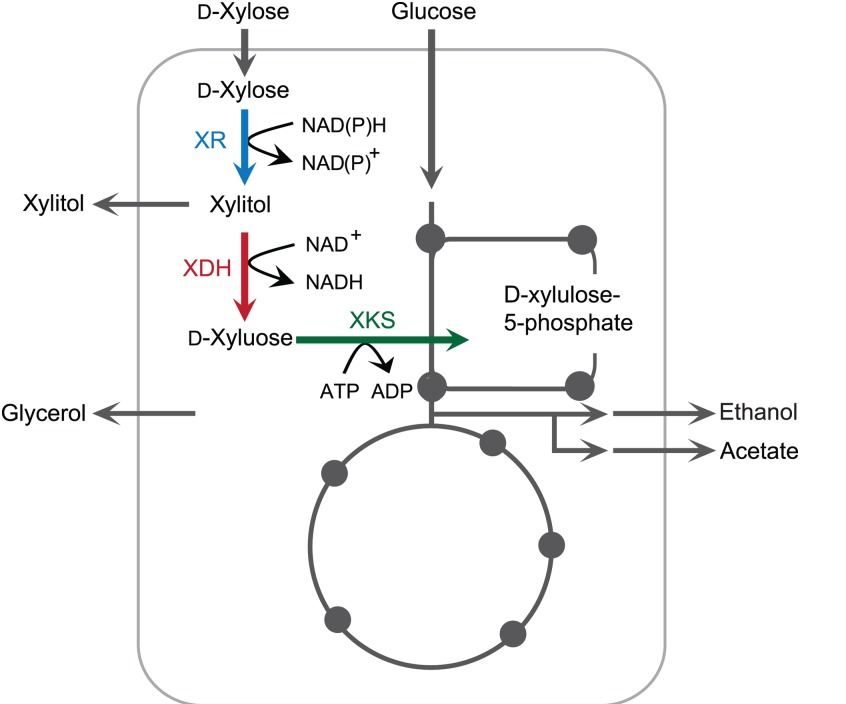

 https://europepmc.org/article/med/23183982

# 1. Default simulation


In [ ]:
# Modifications to GLUCOSE anaerobic fermentation. 
# We need to block xylose and oxygen exchange reactions, and change boundaries of sterols reactions.
# Glucose starts with 10 
model = read_sbml_model('data/iMM904.xml')

envcond = {'EX_glc__D_e':(-10,1000), "EX_xyl__D_e":(0,0), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

res = simul.simulate(method="pFBA")
res


In [ ]:
# XR-XDH pathway

res.find(["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"])

In [ ]:
# Modifications to XYLOSE anaerobic fermentation. 
# We need to block glucose and oxygen exchange reactions, and change boundaries of sterols reactions.
# Xylose starts with 10 

envcond = {'EX_glc__D_e':(0,0), "EX_xyl__D_e":(-10,1000), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

res = simul.simulate(method="pFBA")
res


In [ ]:
res.find(["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"])

# 2. GIMME


In [ ]:
# load expression dataset
expression = pd.read_csv("data/gene_expression_data.txt",sep="\t",index_col=0)
expression.head(5)

In [ ]:
#Example with industrial transcriptomics data during glucose fermentation

envcond = {'EX_glc__D_e':(-10,1000), "EX_xyl__D_e":(0,0), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

#get genes and expression data
genes = expression.index.values
conditions = ["Glucose_medium"]
exp = expression[conditions].to_numpy()

# load expression module
expr = ExpressionSet(genes, conditions, exp)

# Apply GIMME over model
g = GIMME(simul, expr, parsimonious= True)

# Fluxes results
g.values

In [ ]:
res_glu = g.to_dataframe()
res_glu.columns = ["glu_fluxes"]

In [ ]:
res_glu.loc[["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"]]

In [ ]:
#Example with industrial transcriptomics data during xylose fermentation

envcond = {'EX_glc__D_e':(0,0), "EX_xyl__D_e":(-10.0,1000), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

#get genes and expression data
genes = expression.index.values
conditions = ["Xylose_medium"]
exp = expression[conditions].to_numpy()

# load expression module
expr = ExpressionSet(genes, conditions, exp)

# Apply GIMME over model
g = GIMME(simul, expr, parsimonious=True)

# Fluxes results
g.values

In [ ]:
res_xyl = g.to_dataframe()
res_xyl.columns = ["xyl_fluxes"]

In [ ]:
res_xyl.loc[["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"]]

# 3. Escher maps

Lets take a look at the fluxes using Escher maps

In [ ]:
import escher
from escher import Builder

In [ ]:
escher.list_available_maps()

In [ ]:
# Selecting for S. cerevisiae 

builder = Builder(
    map_name='iMM904.Central carbon metabolism',
    model_name='iMM904',
)
builder

In [ ]:
#Glucose with GIMME fluxes
builder.model = model
builder.reaction_data = res_glu

In [ ]:
# Simplify the map by hiding some labels
builder.hide_secondary_metabolites = False
builder.hide_all_labels = False
builder.reaction_scale = [
    { 'type': 'min', 'color': '#000000', 'size': 12 },
    { 'type': 'median', 'color': '#ffffff', 'size': 20 },
    { 'type': 'max', 'color': '#ff0000', 'size': 25 }
]
builder.reaction_scale_preset = 'GaBuRd'
# Make all the arrows three times as thick
builder.reaction_scale = [
    {k: v * 3 if k == 'size' else v for k, v in x.items()}
    for x in builder.reaction_scale
]
builder

In [ ]:
#Xylose with GIMME fluxes
builder.model = model
builder.reaction_data = res_xyl

In [ ]:
# Simplify the map by hiding some labels
builder.hide_secondary_metabolites = False
builder.hide_all_labels = False
builder.reaction_scale = [
    { 'type': 'min', 'color': '#000000', 'size': 12 },
    { 'type': 'median', 'color': '#ffffff', 'size': 20 },
    { 'type': 'max', 'color': '#ff0000', 'size': 25 }
]
builder.reaction_scale_preset = 'GaBuRd'
# Make all the arrows three times as thick
builder.reaction_scale = [
    {k: v * 3 if k == 'size' else v for k, v in x.items()}
    for x in builder.reaction_scale
]
builder

# 4. Comparing the results


In [ ]:
final_result = res_glu.join(res_xyl)
final_result.head(10)

In [ ]:
final_result["delta"] = final_result["glu_fluxes"] - final_result["xyl_fluxes"]
final_result

In [ ]:
# select reactions with difference (column "delta" > 0.5)

select =[]

for index, row in final_result.iterrows():
    res = row['delta']

    if abs(res) > 0.5:
        select.append(index)
select

In [ ]:
# select rows for interesting reactions. Only "delta" column
# create a column called "color" based on the difference over the fluxes

final_result2 = final_result.loc[select]["delta"].to_frame()
final_result2['colors'] = ['red' if x < 0 else 'blue' for x in final_result2['delta']]
final_result2.sort_values('delta', inplace=True)

In [ ]:
# Draw plot
fig= plt.figure(figsize=(14,10), dpi= 300)
plt.hlines(y=final_result2.index, xmin=0, xmax=final_result2["delta"], color=final_result2.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='Reactions', xlabel='$\Delta$ Flux (glucose - xylose)')
plt.yticks(final_result2.index, fontsize=12)
plt.title('Differences betweeen glu and xyl uptake using omics data under industrial conditions', 
          fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [ ]:
#Ethanol
final_result.loc[["EX_etoh_e"]]

# Exercise

1. Load the model;
2. Create a simulation for anaerobic environment;
3. Apply E-Flux algorithm. You can substitute the method using:
    - g = eFlux(simul, expr,parsimonious=True)
4. Compare the results